In [1]:
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import googlemaps
from io import BytesIO
import numpy as np

##### Se hará una selección mas minuciosa respecto a la categorías de interés así como una obtención de tablas para nuestro modelo relacional.

In [ ]:
sitios=pd.read_csv('../google-yelp08/Retaurantes_Datawarehouse.csv')

In [210]:
#Este cambio es para la normalización en la tabla dimensional de Restaurantes
sitios.rename(columns={'gmap_id': 'business_id'}, inplace=True)

In [211]:
sitios.drop(columns=['price','state','relative_results', 'url','avg_rating','num_of_reviews'],inplace=True)


In [236]:
#Función para categorizar puntualmente.
def extract_restaurant_category(row):
            matches = re.findall(r"'([^']*\brestaurant\b[^']*)'", row)
            return ', '.join(matches)

#Algunos archivos no funcionan con nuestra funcion extract_restaurant_category por lo que hay que hacer una adecuación
def convertir_lista_a_cadena(lista):
            cadena_formateada = str(lista)
            return cadena_formateada

In [ ]:
#Copy=df[['business_id','category']].copy()
#Tengo que integrar el ETL completo

In [231]:
if type(sitios['category'].iloc[1]) == list:
    sitios['category'] = sitios['category'].apply(convertir_lista_a_cadena)

In [233]:
sitios['category'] = sitios['category'].apply(extract_restaurant_category)

In [15]:
sitios.shape

(82326, 9)

In [16]:
#Con la transformación anterior se eliminar los que tiene únicamente la palabra Restaurant
sitios['category']=sitios['category'].replace('','Restaurant')

In [ ]:
#Cómo nos interesan los restaurants que tengan definida su categoría quitamos aquellos que
#que están generalizados. 

sitios = sitios[~sitios['category'].str.strip().str.lower().eq('restaurant')]

In [20]:
#Finalmente tenemos 62,850 restaurantes con una categoría definida de interés. 
sitios.reset_index(drop=True, inplace=True)
sitios.shape

(62860, 9)

##### Ahora se hará una selección de categorías, por ende se reducen restaurantes.

In [23]:
sitios['category'] = sitios['category'].astype(str)

In [24]:
sitios = sitios[sitios['category'].str.count(',') == 0]

#### Filtraremos por cantidad de restaurantes según la categoría.

In [25]:
value_counts = sitios['category'].value_counts()

In [27]:
#Seleccionamos las categorías que tengan mas de 150 establecimientos en la misma.
sitios = sitios[sitios['category'].isin(value_counts[value_counts > 150].index)]

#### Realizamos nuestra tabla de categorías.  

In [29]:
pivot_df = pd.pivot_table(sitios, index='business_id', columns='category', aggfunc=lambda x: 1, fill_value=0)

In [30]:
pivot_df

MISC                   \
category                              American restaurant Asian restaurant   
business_id                                                                  
0x146d331735522895:0x7d54db7f15a665c8                   0                0   
0x152043b86515c22f:0x4055bdbbcc5c8eb2                   0                0   
0x152e4b4b3151d2db:0xffe17510575c3d38                   0                0   
0x152f777651683fd3:0xec82a7123a2713e6                   0                0   
0x40544ecd5a4e9add:0xacd71e5487db57cc                   0                0   
...                                                   ...              ...   
0x89fb69fef8c2ddd1:0x1c1432dbfb9ae7da                   0                0   
0x89fb6b26b3fe43ad:0x1c4690cc7e9a6c88                   0                0   
0x89fb6bd43950da25:0xb7d15f5f892ef4e9                   0                0   
0x89fca7475d00eec9:0xf3d10fd0df1ec035                   1                0   
0x89fca75daeb85ee3:0xdb1642638e6c9005                   0                0   

                                                           \
category                              Barbecue restaurant   
business_id                                                 
0x146d331735522895:0x7d54db7f15a665c8                   0   
0x152043b86515c22f:0x4055bdbbcc5c8eb2                   0   
0x152e4b4b3151d2db:0xffe17510575c3d38                   0   
0x152f777651683fd3:0xec82a7123a2713e6                   0   
0x40544ecd5a4e9add:0xacd71e5487db57cc                   0   
...                                                   ...   
0x89fb69fef8c2ddd1:0x1c1432dbfb9ae7da                   0   
0x89fb6b26b3fe43ad:0x1c4690cc7e9a6c88                   0   
0x89fb6bd43950da25:0xb7d15f5f892ef4e9                   1   
0x89fca7475d00eec9:0xf3d10fd0df1ec035                   0   
0x89fca75daeb85ee3:0xdb1642638e6c9005                   0   

                                                            \
category                              Breakfast restaurant   
business_id                                                  
0x146d331735522895:0x7d54db7f15a665c8                    0   
0x152043b86515c22f:0x4055bdbbcc5c8eb2                    0   
0x152e4b4b3151d2db:0xffe17510575c3d38                    1   
0x152f777651683fd3:0xec82a7123a2713e6                    0   
0x40544ecd5a4e9add:0xacd71e5487db57cc                    0   
...                                                    ...   
0x89fb69fef8c2ddd1:0x1c1432dbfb9ae7da                    1   
0x89fb6b26b3fe43ad:0x1c4690cc7e9a6c88                    0   
0x89fb6bd43950da25:0xb7d15f5f892ef4e9                    0   
0x89fca7475d00eec9:0xf3d10fd0df1ec035                    0   
0x89fca75daeb85ee3:0xdb1642638e6c9005                    0   

                                                                               \
category                              Caribbean restaurant Chicken restaurant   
business_id                                                                     
0x146d331735522895:0x7d54db7f15a665c8                    0                  0   
0x152043b86515c22f:0x4055bdbbcc5c8eb2                    0                  0   
0x152e4b4b3151d2db:0xffe17510575c3d38                    0                  0   
0x152f777651683fd3:0xec82a7123a2713e6                    0                  0   
0x40544ecd5a4e9add:0xacd71e5487db57cc                    0                  1   
...                                                    ...                ...   
0x89fb69fef8c2ddd1:0x1c1432dbfb9ae7da                    0                  0   
0x89fb6b26b3fe43ad:0x1c4690cc7e9a6c88                    0                  0   
0x89fb6bd43950da25:0xb7d15f5f892ef4e9                    0                  0   
0x89fca7475d00eec9:0xf3d10fd0df1ec035                    0                  0   
0x89fca75daeb85ee3:0xdb1642638e6c9005                    0                  0   

                                                                \
category                           

In [31]:
pivot_df.reset_index(inplace=True)

Los primeras 36 categorías son las que tienen datos arriba de 150 restaurantes.

In [40]:
primeros_36_valores = value_counts.head(36)

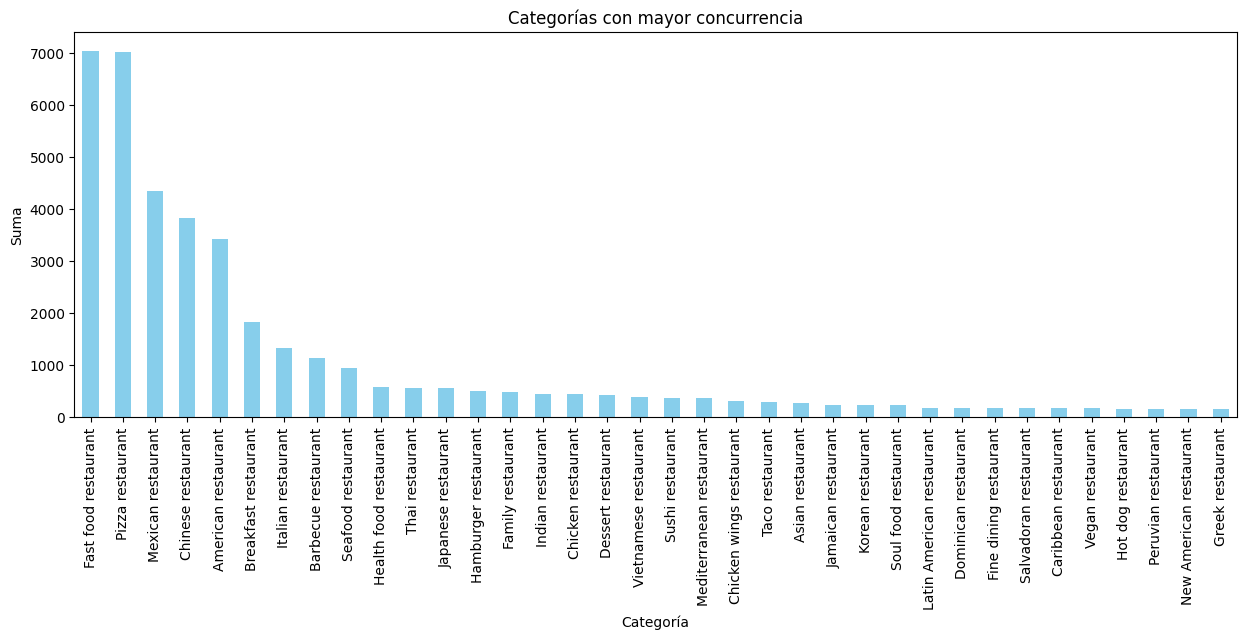

In [41]:
# Graficar las categorías seleccionadas
plt.figure(figsize=(15,5))
primeros_36_valores.plot(kind='bar', color='skyblue')
plt.title('Categorías con mayor concurrencia')
plt.xlabel('Categoría')
plt.ylabel('Suma')
plt.xticks(rotation=90)
plt.show()

#### Filtro de  restaurantes dada su categoría. 

In [42]:
#Estos serán los restaurantes que quedaran al final. 
Ids=sitios['business_id'].tolist()

In [44]:
filtered_df = sitios[sitios['business_id'].isin(Ids)]

In [45]:
filtered_df = filtered_df.reset_index(drop=True)


In [47]:
restautrantes=filtered_df[['business_id','name']].copy()

In [48]:
#Finalmente nos quedamos con 39,301 establecimientos que cuentan con reseñas y 
#categorías de interés. 
filtered_df.shape

(39301, 9)

#### Geographical Data

In [54]:
Datos_Geograficos=filtered_df[['business_id','address','latitude','longitude']].copy()

In [58]:
Datos_Geograficos['address'].isna().sum()

30

In [59]:
#Aquí se obtienen los datos geográficos (address,city,state,postal_code) por separado
#a partir de "address" 

Datos_Geograficos["address"].fillna("Sin dato", inplace=True)

#armo lista con listas para cada columna
nombre_local, direccion, ciudad, codigo_postal = [], [], [], []

for i in Datos_Geograficos["address"]:
    #separo cada string despues de la coma
    parts = i.split(',')

    if len(parts) >= 4:
        nombre_local.append(parts[0].strip()) 
        direccion.append(parts[1].strip())
        ciudad.append(parts[2].strip())
        codigo_postal.append(parts[3].strip())
    else:
        nombre_local.append('')
        direccion.append('')
        ciudad.append('')
        codigo_postal.append('')

df_address = pd.DataFrame({'Name': nombre_local, 'Address': direccion, 'City': ciudad, 'Postal Code': codigo_postal})

# separo la columna postal code en estado y codigo postal
df_address[['Postal Code', 'State']] = df_address['Postal Code'].str.split(n=1, expand=True)

# renombro
df_address.columns = ['Nombre', 'Direccion', 'city', 'state', 'postal_code']

In [60]:
counter = 0
for i in df_address:
    Datos_Geograficos.insert(counter, i, df_address[i])
    counter += 1

In [61]:
Datos_Geograficos.drop(columns=['address','Nombre'],inplace=True)

In [62]:
Datos_Geograficos.rename(columns={'Direccion': 'address'}, inplace=True)

In [63]:
#Tenemos algunos valores faltantes y otros que se obtuvieron de manera errónea
Datos_Geograficos['postal_code'].isna().sum()

1016

In [64]:
Datos_Geograficos['postal_code'].fillna('Sin Dato',inplace=True)

In [65]:
#Separaremos los restaurantes mal llenados bajo la lógica de que deberían ser números
resultados = Datos_Geograficos[-Datos_Geograficos['postal_code'].apply(lambda x: x.isdigit())]

In [66]:
resultadosresultados = resultados.reset_index(drop=True)

###### Para los que se llenaron de mala manera, usaremos una API de google, a la cual se le pasaran la latitud y longitud.

In [67]:
# Función para obtener la dirección, ciudad, estado y CP a partir de la latitud y longitud.
def obtener_direccion(latitud, longitud):
    # Hacer una solicitud de geocodificación inversa.
    resultado = gmaps.reverse_geocode((latitud, longitud))
    
    # Inicializar valores por defecto.
    direccion = ''
    ciudad = ''
    estado = ''
    cp = ''
    
    # Si hay resultados, buscar la información relevante.
    if resultado:
        primer_resultado = resultado[0]
        direccion = primer_resultado.get('formatted_address', '')
        for componente in primer_resultado['address_components']:
            tipos = componente.get('types', [])
            if 'locality' in tipos:
                ciudad = componente.get('long_name', '')
            elif 'administrative_area_level_1' in tipos:
                estado = componente.get('short_name', '')
            elif 'postal_code' in tipos:
                cp = componente.get('long_name', '')
    
    return direccion, ciudad, estado, cp

In [68]:
# Iterar sobre las filas y actualizar las columnas con los resultados.
for index, row in resultados.iterrows():
    direccion, ciudad, estado, cp = obtener_direccion(row['latitude'], row['longitude'])
    resultados.at[index, 'address'] = direccion
    resultados.at[index, 'city'] = ciudad
    resultados.at[index, 'state'] = estado
    resultados.at[index, 'postal_code'] = cp
# Ahora, el DataFrame "df" contiene las columnas de dirección, ciudad, estado y CP con la información correspondiente.

In [120]:
resultados[resultados['business_id'] == '0x88e78391721f7c4d:0x7d299b4c817c5af6']

,address,city,state,postal_code,business_id,latitude,longitude
4895,"13369 W Colonial Dr, Winter Garden, FL 34787, USA",Winter Garden,FL,34787,0x88e78391721f7c4d:0x7d299b4c817c5af6,28.551761,-81.580783


In [ ]:
#Se hace pasa el 'business_id' al indice para poder unirlos.
Datos_Geograficos.set_index('business_id', inplace=True)
resultados.set_index('business_id', inplace=True)

In [126]:
#Se unen los datos nuevos que se han tratado.
Datos_Geograficos.update(resultados)

In [134]:
Datos_Geograficos.shape

(39301, 7)

In [132]:
Datos_Geograficos.reset_index(inplace=True)

### Horarios

In [279]:
Horarios=filtered_df[['business_id','hours']].copy()

In [280]:
Horarios.shape

(39301, 2)

In [281]:
Horarios['hours'].isna().sum()

1780

In [282]:
Horarios['hours'].fillna("[['Thursday', 'Sin Dato'], ['Friday', 'Sin Dato'], ['Saturday', 'Sin Dato'], ['Sunday', 'Sin Dato'], ['Monday', 'Sin Dato'],['Tuesday', 'Sin Dato'], ['Wednesday', 'Sin Dato']]", inplace=True)

In [283]:
dataframes_individuales = []

for _, row in Horarios.iterrows():
    try:
        lista_horarios = ast.literal_eval(row['hours'])
        df = pd.DataFrame(lista_horarios, columns=['Dia', 'Horario'])
        df['business_id'] = row['business_id']
        dataframes_individuales.append(df)
    except (ValueError, SyntaxError):
        pass  # Ignora las filas con valores NaN o cadenas mal formadas.

# Concatena todos los DataFrames individuales en uno solo.
tabla_pivot_total = pd.concat(dataframes_individuales)

# Pivotea la tabla.
Tabla_Horarios = tabla_pivot_total.pivot(index='business_id', columns='Dia', values='Horario')

In [290]:
Tabla_Horarios=Tabla_Horarios.reset_index()

MISC

In [ ]:
MISC_copy=filtered_df[['business_id','MISC']].copy()

In [ ]:
MISC_copy.isna().sum()

In [ ]:
MISC_copy = MISC_copy.replace('null', np.nan)
MISC_copy['MISC'] = MISC_copy['MISC'].fillna('{}')

In [ ]:
MISC_copy['MISC'] = MISC_copy['MISC'].apply(ast.literal_eval)

In [ ]:
df_expanded = pd.json_normalize(MISC_copy['MISC'].tolist())

In [ ]:
MISC_df = pd.concat([MISC_copy.drop('MISC', axis=1), df_expanded], axis=1)
MISC_df=MISC_df.set_index('business_id')

In [ ]:
# Función para extraer el texto de una lista de cadenas
def extraer_texto(lista):
    if isinstance(lista, list):
        return ', '.join([item for item in lista if isinstance(item, str)])
    return np.NaN
MISC_df = MISC_df.applymap(extraer_texto)
MISC_df.reset_index(inplace=True)
MISC_df.rename(columns={'index': 'business_id'}, inplace=True) 

In [ ]:
MISC_df = MISC_df.rename(columns={'From the business': 'From_the_business','Service options':'Service_options','Health & safety':'Health_safety','Popular for':'Popular_for','Dining options':'Dining_options'})